In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from variation_relax import preprocess_mesh, relax_bending
from plot import plot_dots
import os


file = Path('coordinates/Membrane_2018June_Tomo26_CME_Invagination.txt')

# n_vertices_values = [50, 100, 200, 400]
n_vertices_values = [800, 1600]

for n_vertices in n_vertices_values:

    coords, original_coords = preprocess_mesh(file, resample_geometry=True, n_vertices=n_vertices)
    
    params = {
        "Kb": 10,
        "Ksg": 10,
        "Ksl": 10,
        "dt": 1e-5,
        # "n_iter": int(8e2),
        "n_iter": int(1e5),
        "boundary": "pinned",
    }
    relaxed_coords = relax_bending(coords, **params)
    
    file_path = os.path.join(f"dat/mesh_test", f"coords_n{n_vertices:03d}.npy")
    np.save(file_path, relaxed_coords)



Energy relaxation:   0%|          | 0/100000 [00:00<?, ?it/s]

Energy relaxation:   0%|          | 0/100000 [00:00<?, ?it/s]

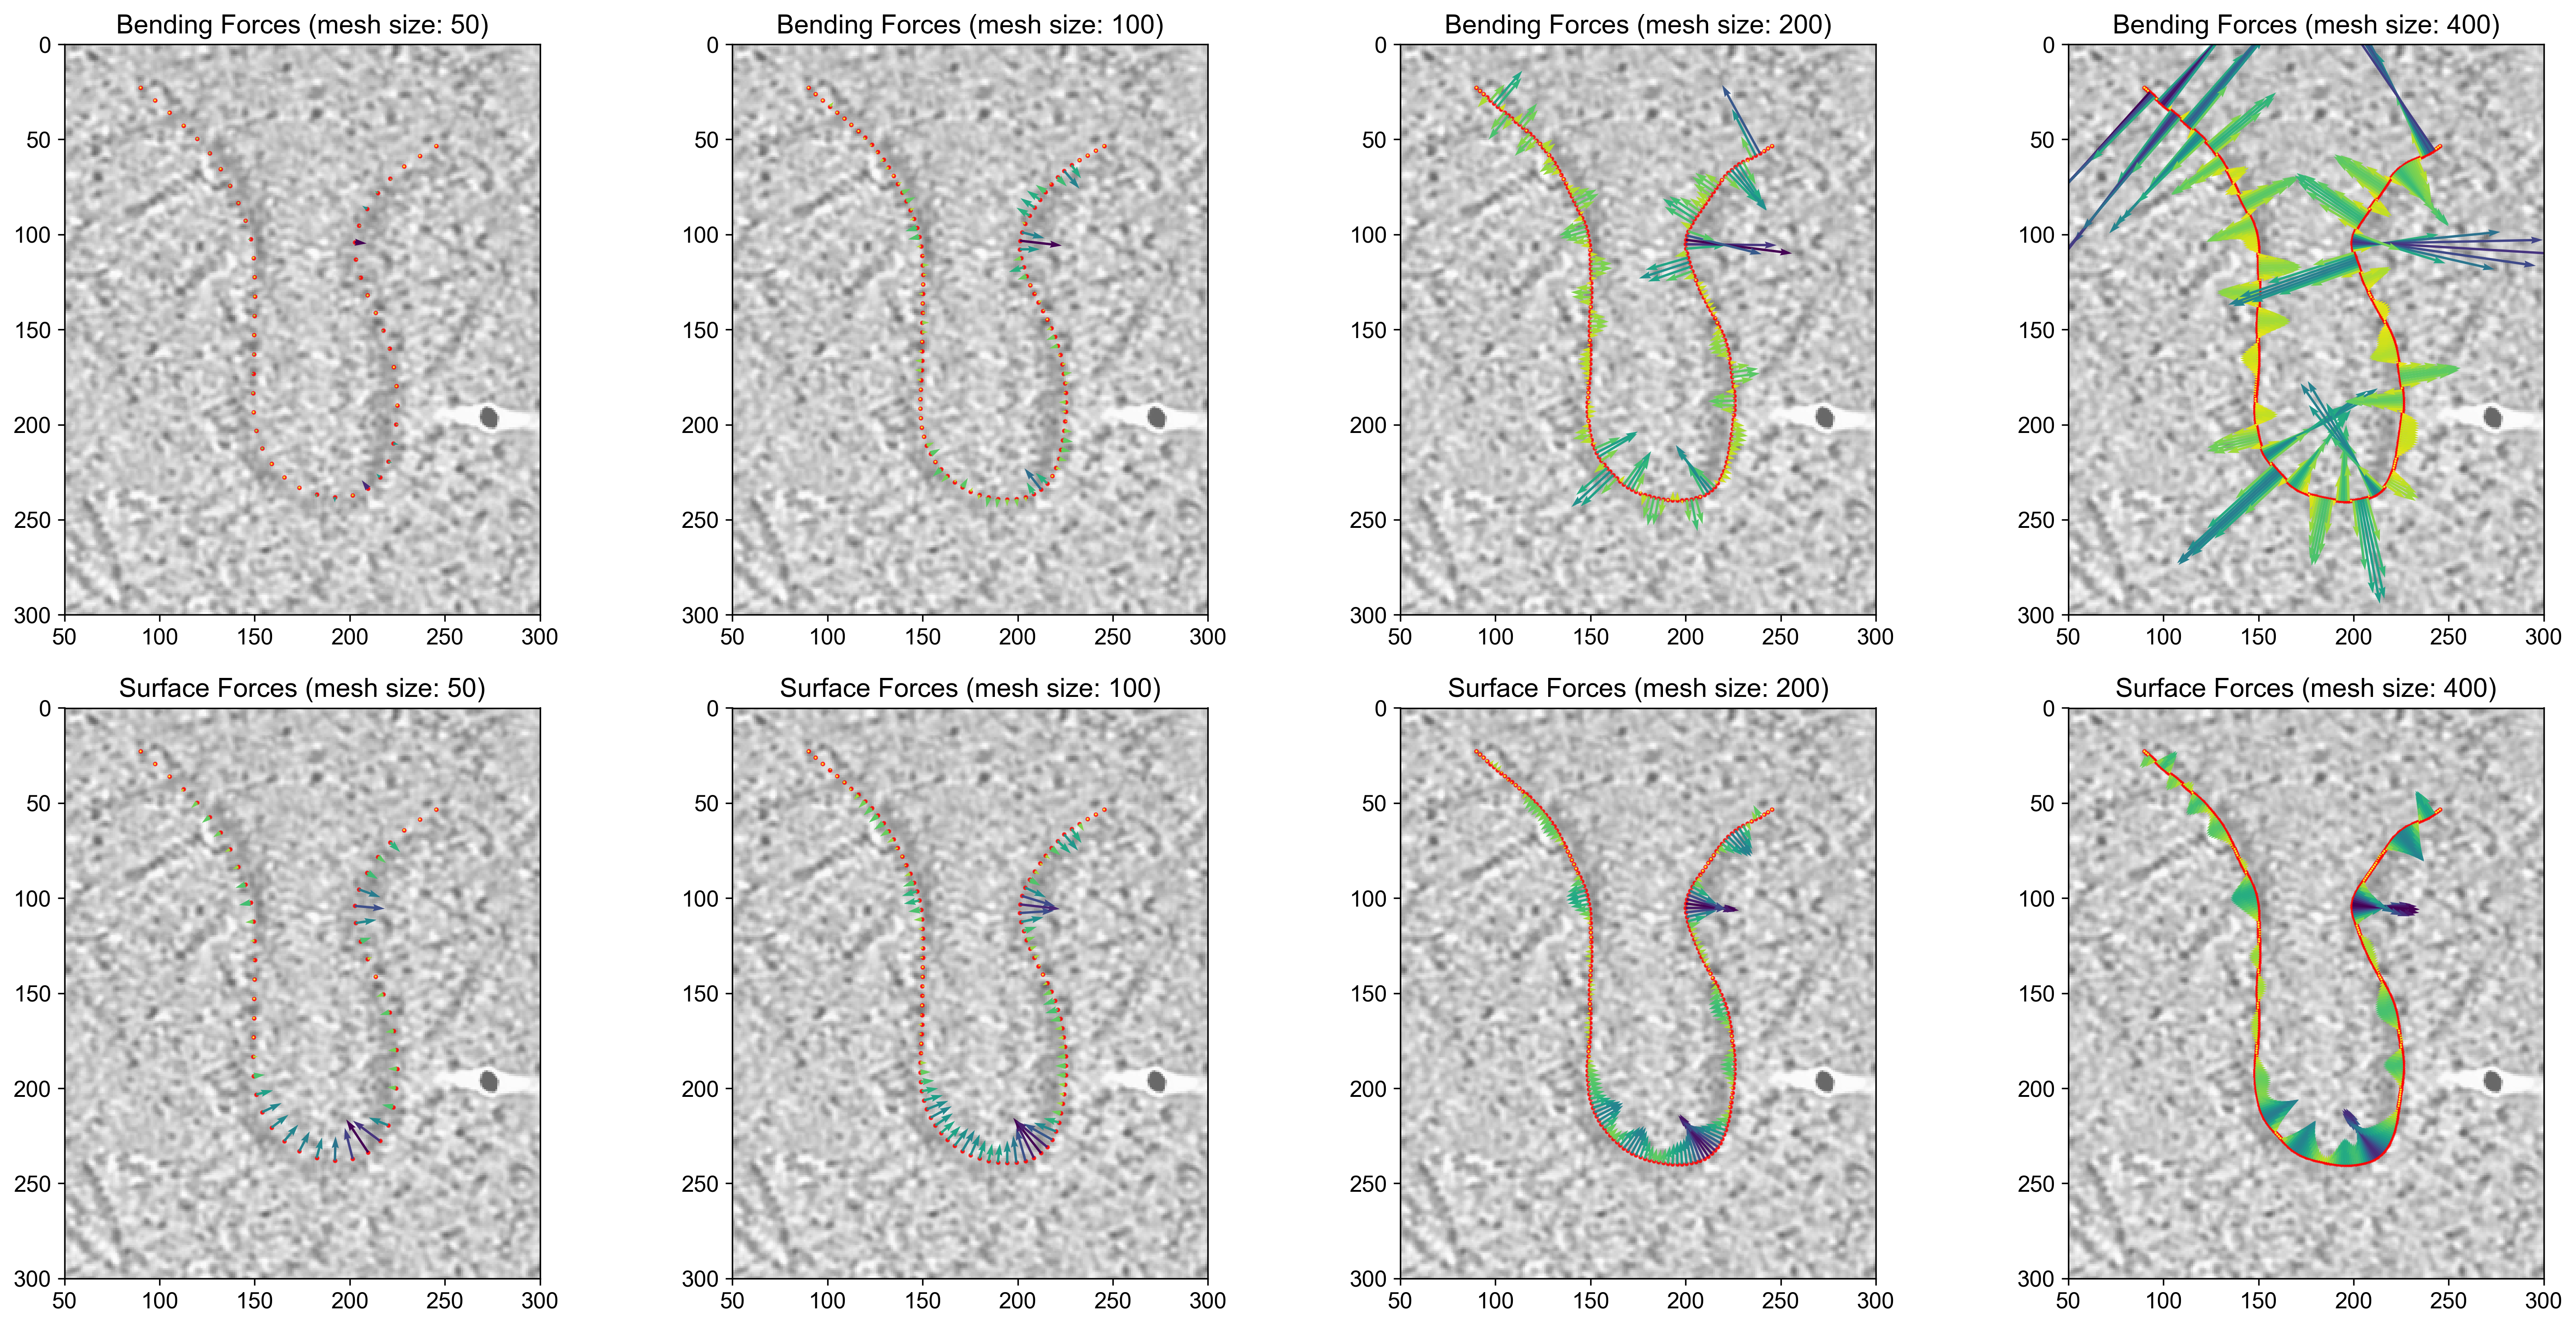

In [2]:
import numpy as np
import numpy.typing as npt
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from variation_run import get_force_density, get_force
from automembrane.energy import OpenPlaneCurveMaterial
from automembrane.geometry import OpenPlaneCurveGeometry
from plot import load_image, shift_coords, resize_image

def plot_coord_force(
    file_stem: str,
    coord: npt.NDArray[np.float64],
    force: npt.NDArray[np.float64],
    ax,
    xlim=None,
    ylim=(300, -50),
    scale_factor: float = 0.003,
):
    coord_x, coord_y = shift_coords(coord)
    
    image = load_image(file_stem)
    resized_image = resize_image(image, 0.6/1.1)
    
    ax.imshow(resized_image, cmap='gray', alpha=0.6)

    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # Scatter plot of the coordinates
    ax.scatter(coord_x, coord_y, color='red', s=2, alpha=0.8)

    # Compute force magnitudes and plot with quiver
    f_mag = np.linalg.norm(force, axis=1)
    ax.quiver(
        coord_x,
        coord_y,
        force[:, 0],
        force[:, 1],
        f_mag,
        cmap=mpl.cm.viridis_r,
        # color="red",
        angles="xy",
        scale=scale_factor,
        scale_units="xy",
        width=0.005,
    )


# File and parameters setup
file = Path('coordinates/Membrane_2018June_Tomo26_CME_Invagination.txt')
parameters = {
    "Kb": 100/4,  # Bending modulus (pN um; original 1e-19 J)
    "Ksg": 0.5,  # Global stretching modulus (pN um/um^2; original 0.05 mN/m)
    "Ksl": 0,    # Regularization modulus (pN um; 0), 
    "boundary": "fixed"
}

n_vertices_values = [50, 100, 200, 400]
# n_vertices_values = [200, 400, 800, 1600]
types = ["bend", "surf"]

# Create a figure with subplots (2 rows for "bend" and "surf", columns for each n_vertices)
fig, axes = plt.subplots(len(types), len(n_vertices_values), figsize=(20, 10))

for row_idx, type in enumerate(types):
    
    for col_idx, n_vertices in enumerate(n_vertices_values):
        
        # Load coordinates and forces
        coords = np.load(f"dat/mesh_test/coords_n{n_vertices:03d}.npy")
        forces = get_force_density(parameters, coords)
        # forces = get_force(parameters, coords)
        
        # Select the corresponding subplot
        ax = axes[row_idx, col_idx]

        # Call plot_coord_force and pass the specific subplot
        plot_coord_force(
            file.stem, 
            coords,
            forces[row_idx, :],  # Use forces for either "bend" or "surf" depending on the row
            ax=ax,  # Pass the subplot axis
            xlim=(50, 300), 
            ylim=(300, 0), 
            scale_factor=0.001,
        )
        
        # Set title for each plot (e.g., Bending Force (Mesh size: 50), Surface Force (Mesh size: 50))
        force_type = "Bending Forces" if type == "bend" else "Surface Forces"
        ax.set_title(f"{force_type} (mesh size: {n_vertices})")

# Adjust layout for better spacing between plots
plt.tight_layout()
# plt.savefig(f"figures/mesh_test/force_dist_bud.png", dpi=300)
plt.show()



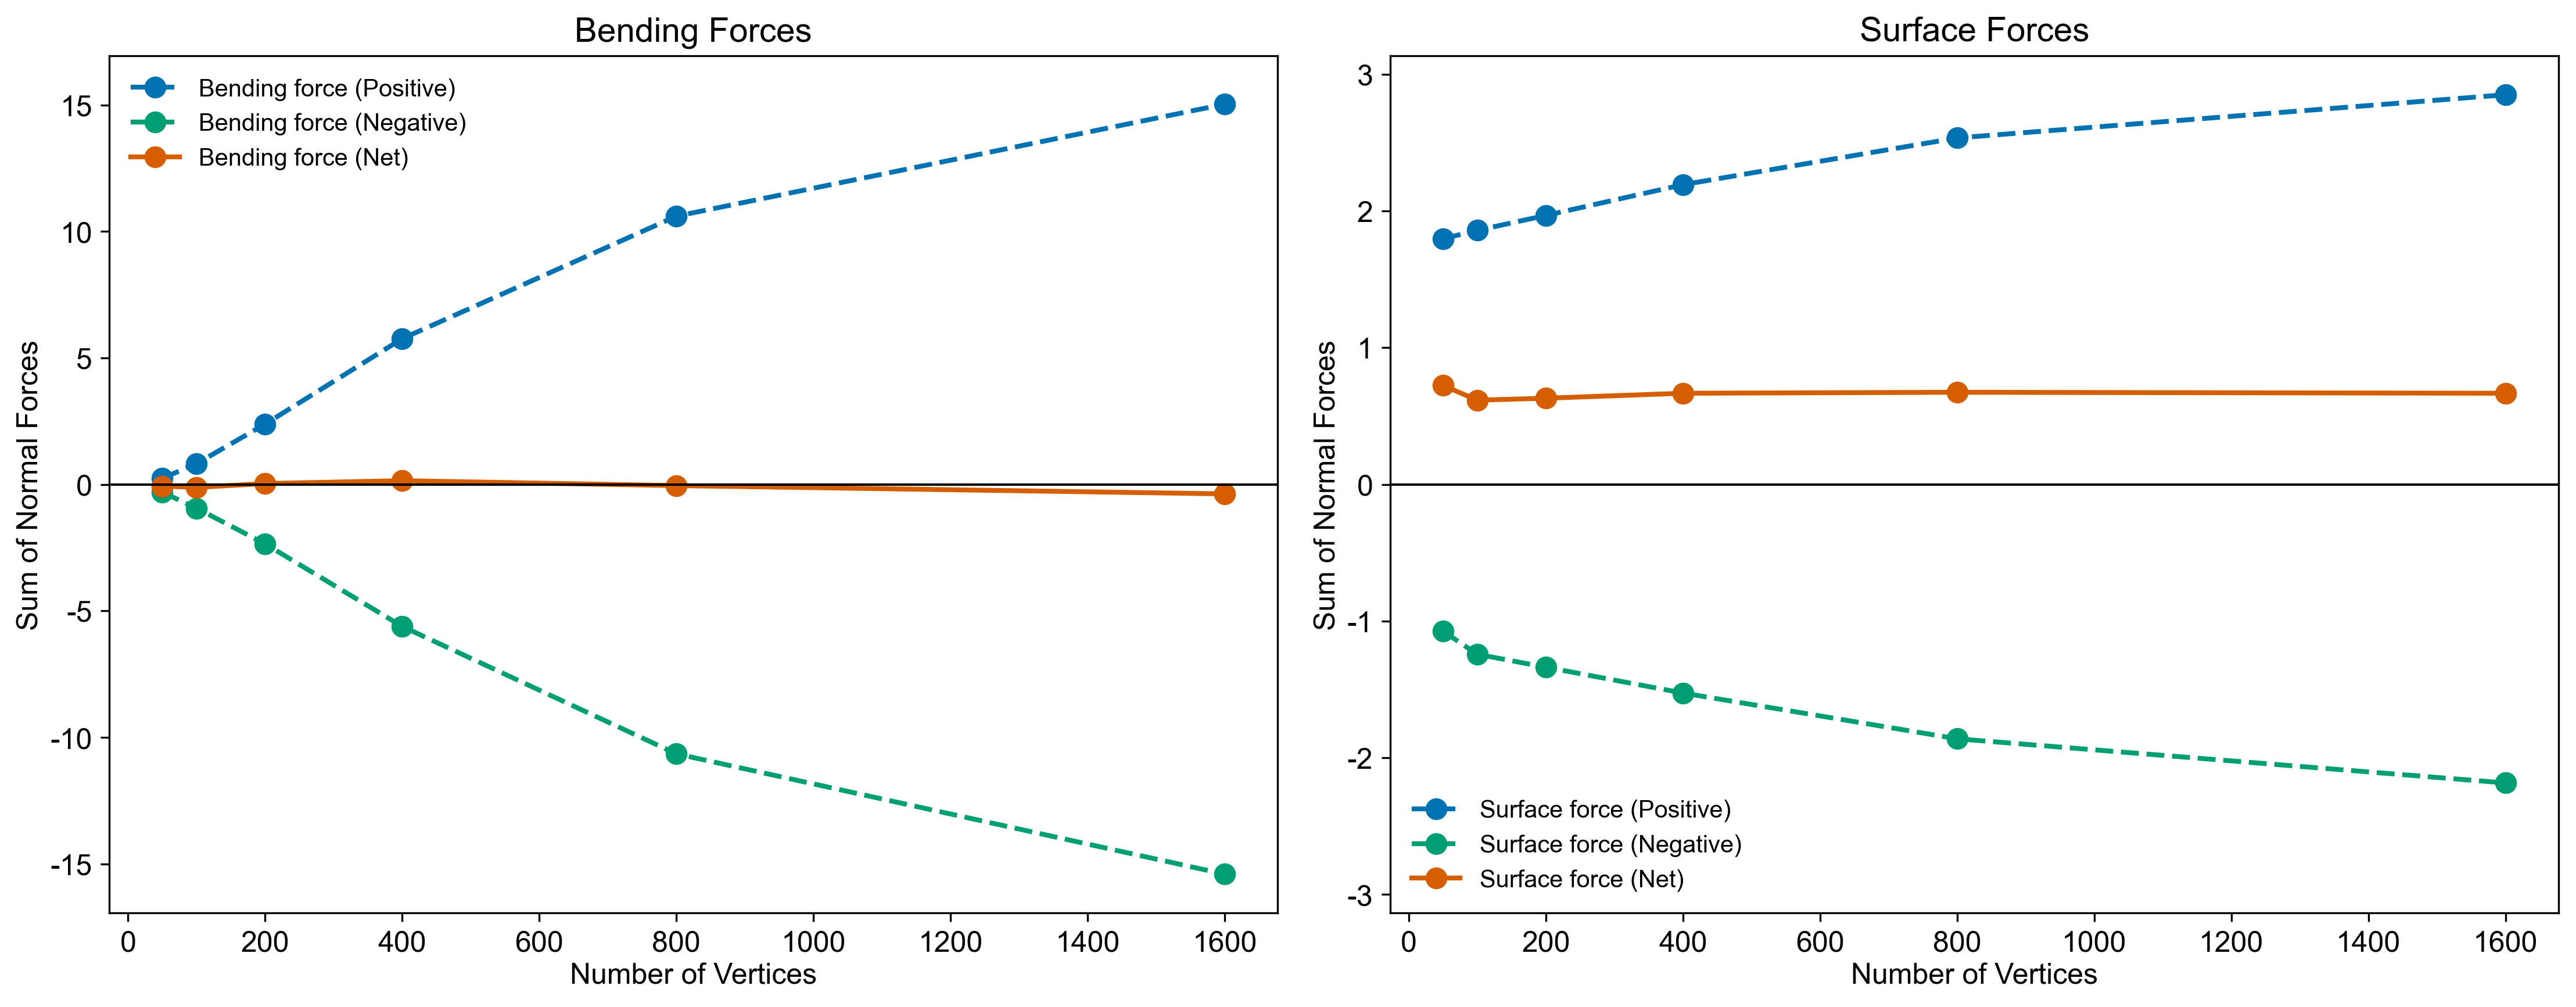

In [49]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from variation_run import get_force_density, get_force
from plot import plot_coord_force, plot_coord_curve_force
from automembrane.energy import OpenPlaneCurveMaterial
from automembrane.geometry import OpenPlaneCurveGeometry


file = Path('coordinates/Membrane_2018June_Tomo26_CME_Invagination.txt')
parameters = {
    "Kb": 100/4,  # Bending modulus (pN um; original 1e-19 J)
    "Ksg": 0.5,  # Global stretching modulus (pN um/um^2; original 0.05 mN/m)
    "Ksl": 0,    # Regularization modulus (pN um; 0), 
    "boundary": "fixed"
}

n_vertices_values = [50, 100, 200, 400]
n_vertices_values = [50, 100, 200, 400, 800, 1600]
force_sums_bend = []
force_sums_surf = []

for n_vertices in n_vertices_values:
    
    coords = np.load(f"dat/mesh_test/coords_n{n_vertices:03d}.npy")
    # forces = get_force_density(parameters, coords)
    forces = get_force(parameters, coords) * OpenPlaneCurveGeometry.vertex_normal(coords)

    positive_force_bend = np.sum(forces[0, forces[0, :] > 0])  # Sum for force > 0
    negative_force_bend = np.sum(forces[0, forces[0, :] < 0])  # Sum for force < 0
    net_force_bend = np.sum(forces[0, :])                      # Net force
    force_sums_bend.append([positive_force_bend, negative_force_bend, net_force_bend])

    positive_force_surf = np.sum(forces[1, forces[1, :] > 0])  # Sum for force > 0
    negative_force_surf = np.sum(forces[1, forces[1, :] < 0])  # Sum for force < 0
    net_force_surf = np.sum(forces[1, :])                      # Net force
    force_sums_surf.append([positive_force_surf, negative_force_surf, net_force_surf])


positive_force_bend = [fs[0] for fs in force_sums_bend]
negative_force_bend = [fs[1] for fs in force_sums_bend]
net_force_bend = [fs[2] for fs in force_sums_bend]

positive_force_surf = [fs[0] for fs in force_sums_surf]
negative_force_surf = [fs[1] for fs in force_sums_surf]
net_force_surf = [fs[2] for fs in force_sums_surf]


# Plotting individual plots for bending and surface forces side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for bending forces
axes[0].plot(n_vertices_values, positive_force_bend, label='Bending force (Positive)', marker='o', linestyle='--', markersize=8)
axes[0].plot(n_vertices_values, negative_force_bend, label='Bending force (Negative)', marker='o', linestyle='--', markersize=8)
axes[0].plot(n_vertices_values, net_force_bend, label='Bending force (Net)', marker='o', linestyle='-', markersize=8)

axes[0].set_xlabel('Number of Vertices')
axes[0].set_ylabel('Sum of Normal Forces')
axes[0].set_title('Bending Forces')
axes[0].legend()
axes[0].grid(True)

# Plot for surface forces
axes[1].plot(n_vertices_values, positive_force_surf, label='Surface force (Positive)', marker='o', linestyle='--', markersize=8)
axes[1].plot(n_vertices_values, negative_force_surf, label='Surface force (Negative)', marker='o', linestyle='--', markersize=8)
axes[1].plot(n_vertices_values, net_force_surf, label='Surface force (Net)', marker='o', linestyle='-', markersize=8)
axes[1].set_xlabel('Number of Vertices')
axes[1].set_ylabel('Sum of Normal Forces')
axes[1].set_title('Surface Forces')
axes[1].legend()
axes[1].grid(True)


# Set symmetric y-limits around zero
y_max_bend = max(abs(min(negative_force_bend)), max(positive_force_bend)) * 1.1
y_max_surf = max(abs(min(negative_force_surf)), max(positive_force_surf)) * 1.1

axes[0].set_ylim(-y_max_bend, y_max_bend)  # Bending forces y-limits
axes[1].set_ylim(-y_max_surf, y_max_surf)  # Surface forces y-limits

# Remove the grid on the y-axis, but keep the x-axis grid if desired
axes[0].grid(False)  # Remove all grid lines
axes[1].grid(False)

# Add a bold horizontal line at y=0
axes[0].axhline(0, color='black', linewidth=1)  # Add bold y=0 line on first plot
axes[1].axhline(0, color='black', linewidth=1)  # Add bold y=0 line on second plot



# Adjust layout for clarity
plt.tight_layout()

plt.savefig(f"figures/mesh_test/normal_force_bud.png", dpi=300)
plt.show()

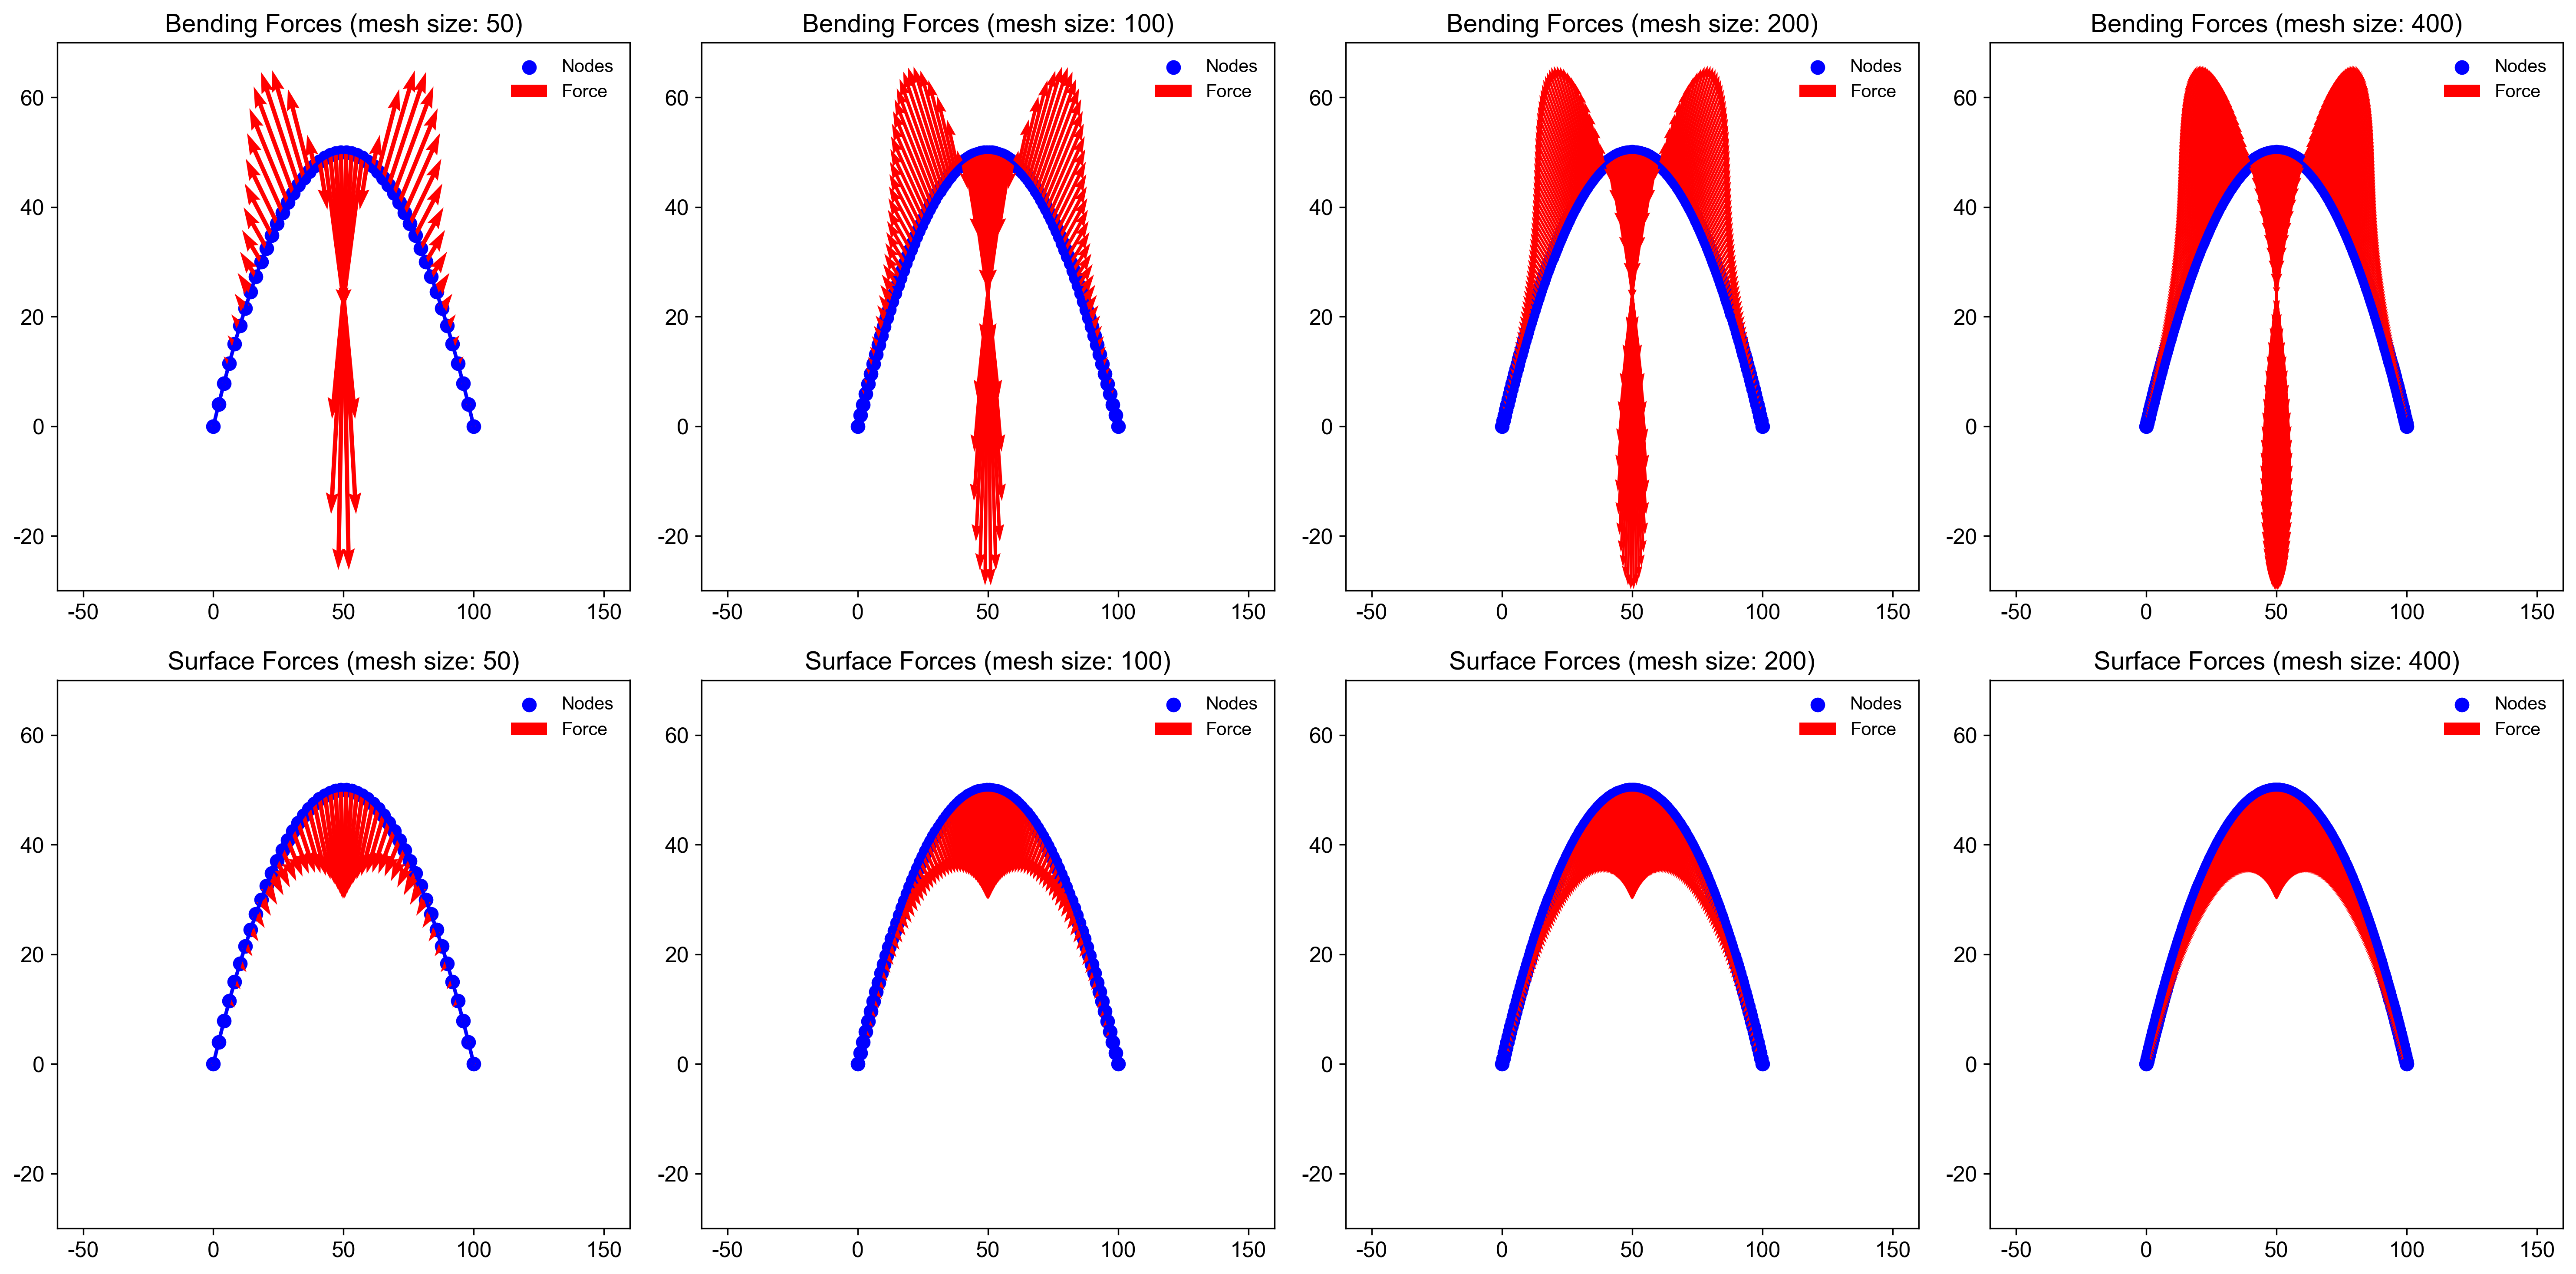

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sample import make_parabola, plot_parabola_ax
from variation_run import get_force_density, get_force
from automembrane.geometry import OpenPlaneCurveGeometry

# N_node = 50
L_etoe = 100
height = 50

parameters = {
    "Kb":  100 / 4,   # Bending modulus (pN nm)
    "Ksg": 0.5,    # Global stretching modulus (pN nm)
    "Ksl": 0,
    "boundary": "fixed"
}

N_node_values = [50, 100, 200, 400]
# N_node_values = [50, 100, 200, 400, 800, 1600]

# Create subplots for side by side plotting: 2 rows (bending and surface) and len(N_node_values) columns
fig, axes = plt.subplots(2, len(N_node_values), figsize=(20, 10))  # 2 rows for bend/surf, columns for mesh sizes

for idx, N_node in enumerate(N_node_values):

    # Generate coordinates and forces
    coords = make_parabola(N_node=N_node, L_etoe=L_etoe, height=height, point_dist="unif")
    force = get_force_density(parameters, coords)

    # Plot Bending Force (row 0)
    plot_parabola_ax(coords, force[0], ax=axes[0, idx], mesh_size=N_node, force_type="Bending Forces", scale=10)
    
    # Plot Surface Force (row 1)
    plot_parabola_ax(coords, force[1], ax=axes[1, idx], mesh_size=N_node, force_type="Surface Forces", scale=100)

# Adjust layout to ensure side by side alignment
plt.tight_layout()
plt.savefig(f"figures/mesh_test/force_dist_parabola.png", dpi=300)
plt.show()


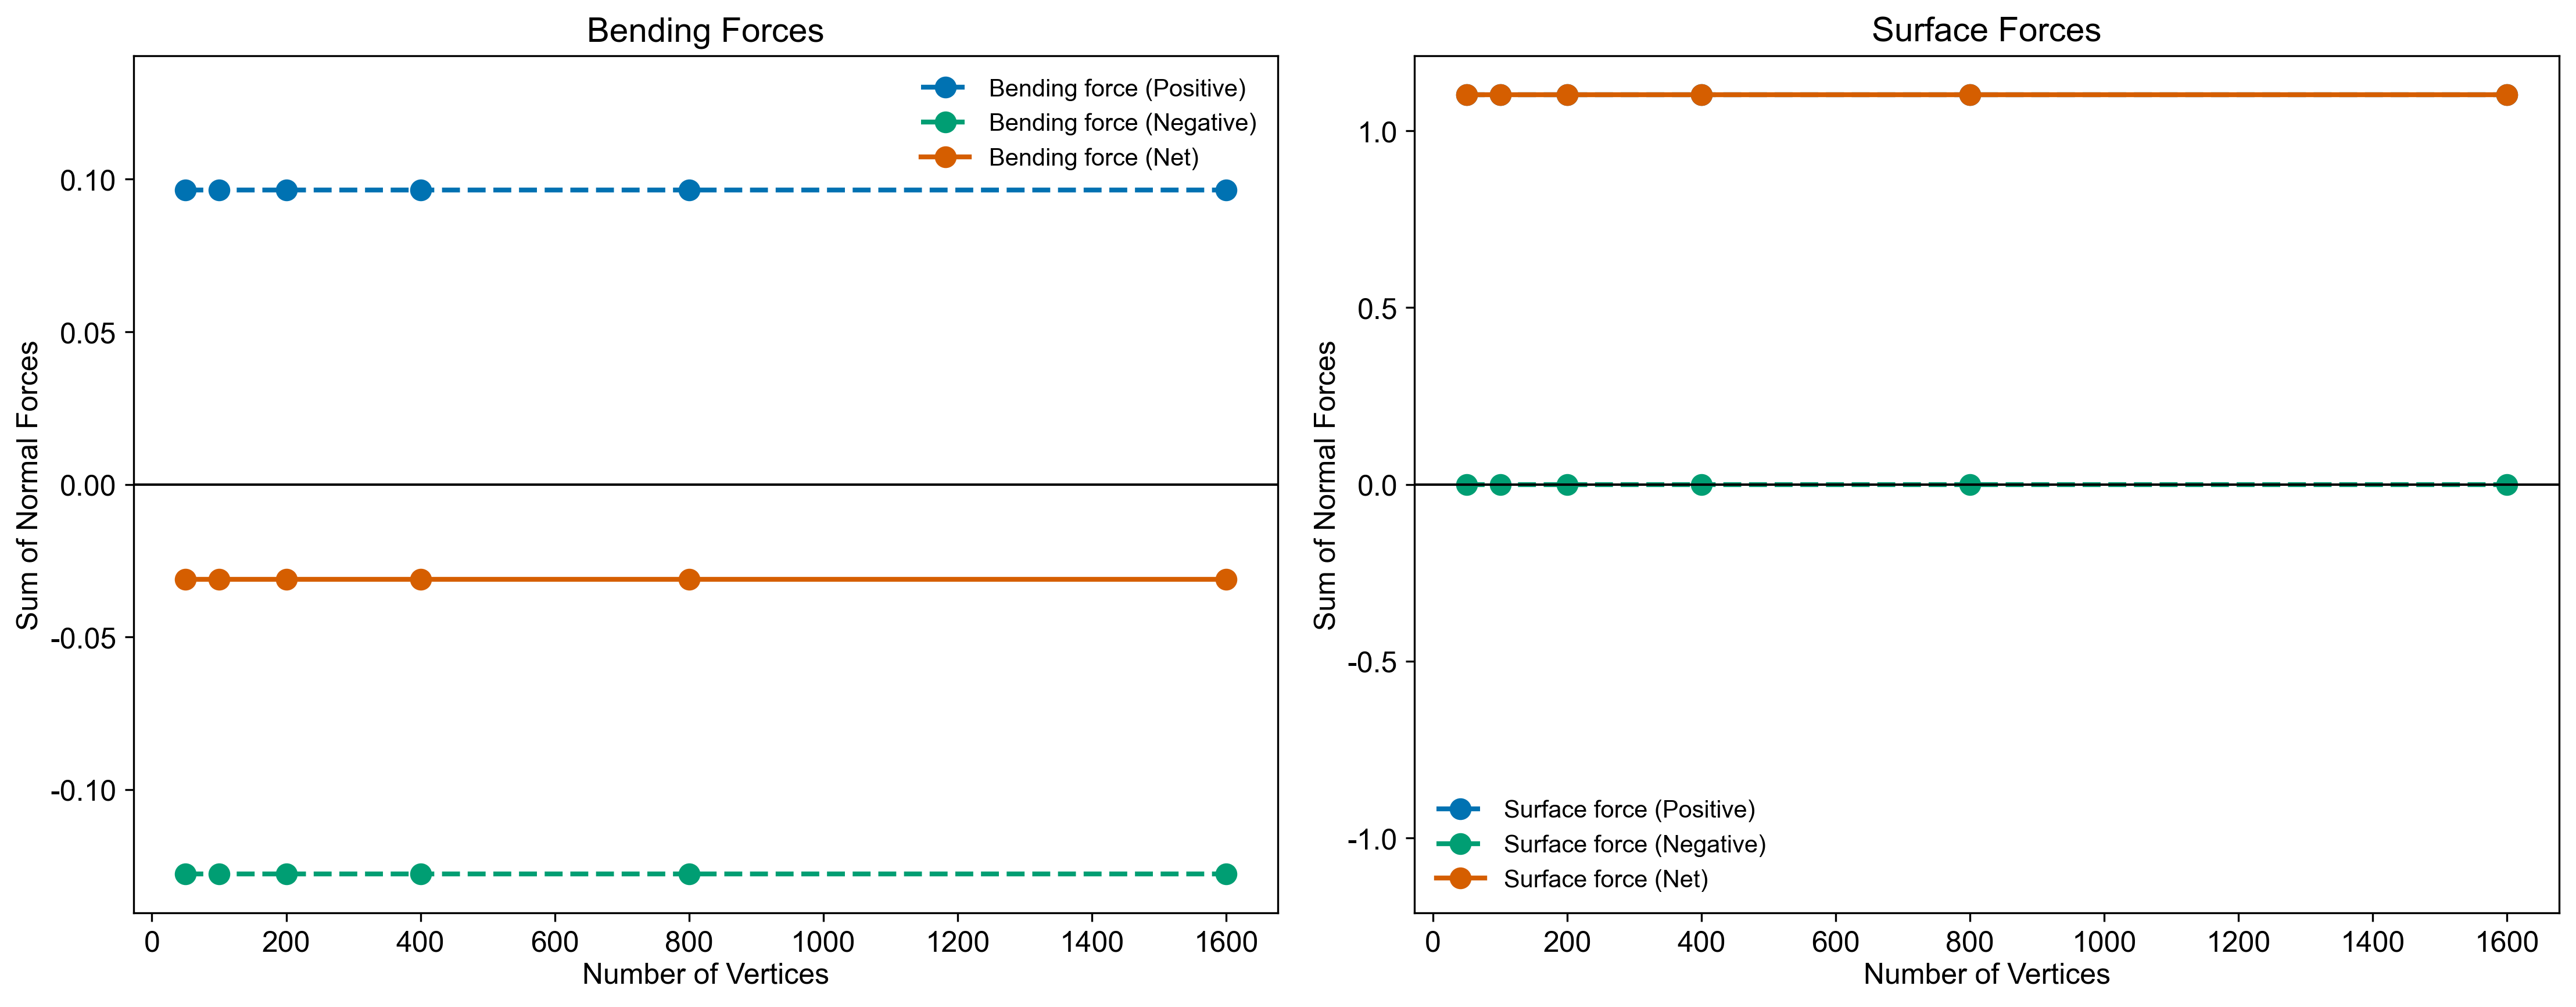

In [2]:
from sample import make_parabola, plot_parabola, plot_norm_side_by_side
from variation_run import get_force_density, get_force
from automembrane.geometry import OpenPlaneCurveGeometry

# N_node = 50
L_etoe = 100
height = 50

parameters = {
    "Kb":  100 / 4,   # Bending modulus (pN nm)
    # "Ksg": 0,    # Global stretching modulus (pN nm)
    "Ksg": 0.5,    # Global stretching modulus (pN nm)
    "Ksl": 0,
    "boundary": "fixed"
}

N_node_values = [50, 100, 200, 400]
N_node_values = [50, 100, 200, 400, 800, 1600]
force_sums_bend = []
force_sums_surf = []

for N_node in N_node_values:

    coords = make_parabola(N_node = N_node, L_etoe = L_etoe, height = height, point_dist = "unif")

    # force = get_force(parameters, coords)
    force = get_force(parameters, coords) * OpenPlaneCurveGeometry.vertex_normal(coords)

    positive_force_bend = np.sum(forces[0, forces[0, :] > 0])  # Sum for force > 0
    negative_force_bend = np.sum(forces[0, forces[0, :] < 0])  # Sum for force < 0
    net_force_bend = np.sum(forces[0, :])                      # Net force
    force_sums_bend.append([positive_force_bend, negative_force_bend, net_force_bend])

    positive_force_surf = np.sum(forces[1, forces[1, :] > 0])  # Sum for force > 0
    negative_force_surf = np.sum(forces[1, forces[1, :] < 0])  # Sum for force < 0
    net_force_surf = np.sum(forces[1, :])                      # Net force
    force_sums_surf.append([positive_force_surf, negative_force_surf, net_force_surf])


# Plotting individual plots for bending and surface forces side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

plot_norm_side_by_side(N_node_values, force_sums_bend, force_sums_surf, axes)

# Adjust layout for clarity
plt.tight_layout()

plt.savefig(f"figures/mesh_test/normal_force_parabola.png", dpi=300)
plt.show()





In [4]:
# Parabola with noise

from sample import make_parabola, plot_parabola
from variation_relax import resample, relax_bending
import os
import numpy as np

N_node = 100
L_etoe = 100
height = 50
noise_level = 0.5
ori_coords = make_parabola(N_node = N_node, L_etoe = L_etoe, height = height, point_dist = "unif", noise_level = noise_level)


# n_vertices_values = [50, 100, 200, 400]
# n_vertices_values = [800, 1600]
n_vertices_values = [50, 100, 200, 400, 800, 1600]

params = {
    "Kb": 10,
    "Ksg": 10,
    "Ksl": 10,
    "dt": 1e-5,
    # "n_iter": int(8e2), # debug
    "n_iter": int(1e5),
    "boundary": "pinned",
}

for n_vertices in n_vertices_values:

    coords, _ = resample(ori_coords, n_vertices)
    relaxed_coords = relax_bending(coords, **params)

    file_path = os.path.join(f"dat/mesh_test", f"noise_n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}.npz")
    np.savez(file_path, coords = relaxed_coords, ori_coords = ori_coords)

# plot_parabola(relaxed_coords)

Energy relaxation:   0%|          | 0/100000 [00:00<?, ?it/s]

Energy relaxation:   0%|          | 0/100000 [00:00<?, ?it/s]

Energy relaxation:   0%|          | 0/100000 [00:00<?, ?it/s]

Energy relaxation:   0%|          | 0/100000 [00:00<?, ?it/s]

Energy relaxation:   0%|          | 0/100000 [00:00<?, ?it/s]

Energy relaxation:   0%|          | 0/100000 [00:00<?, ?it/s]

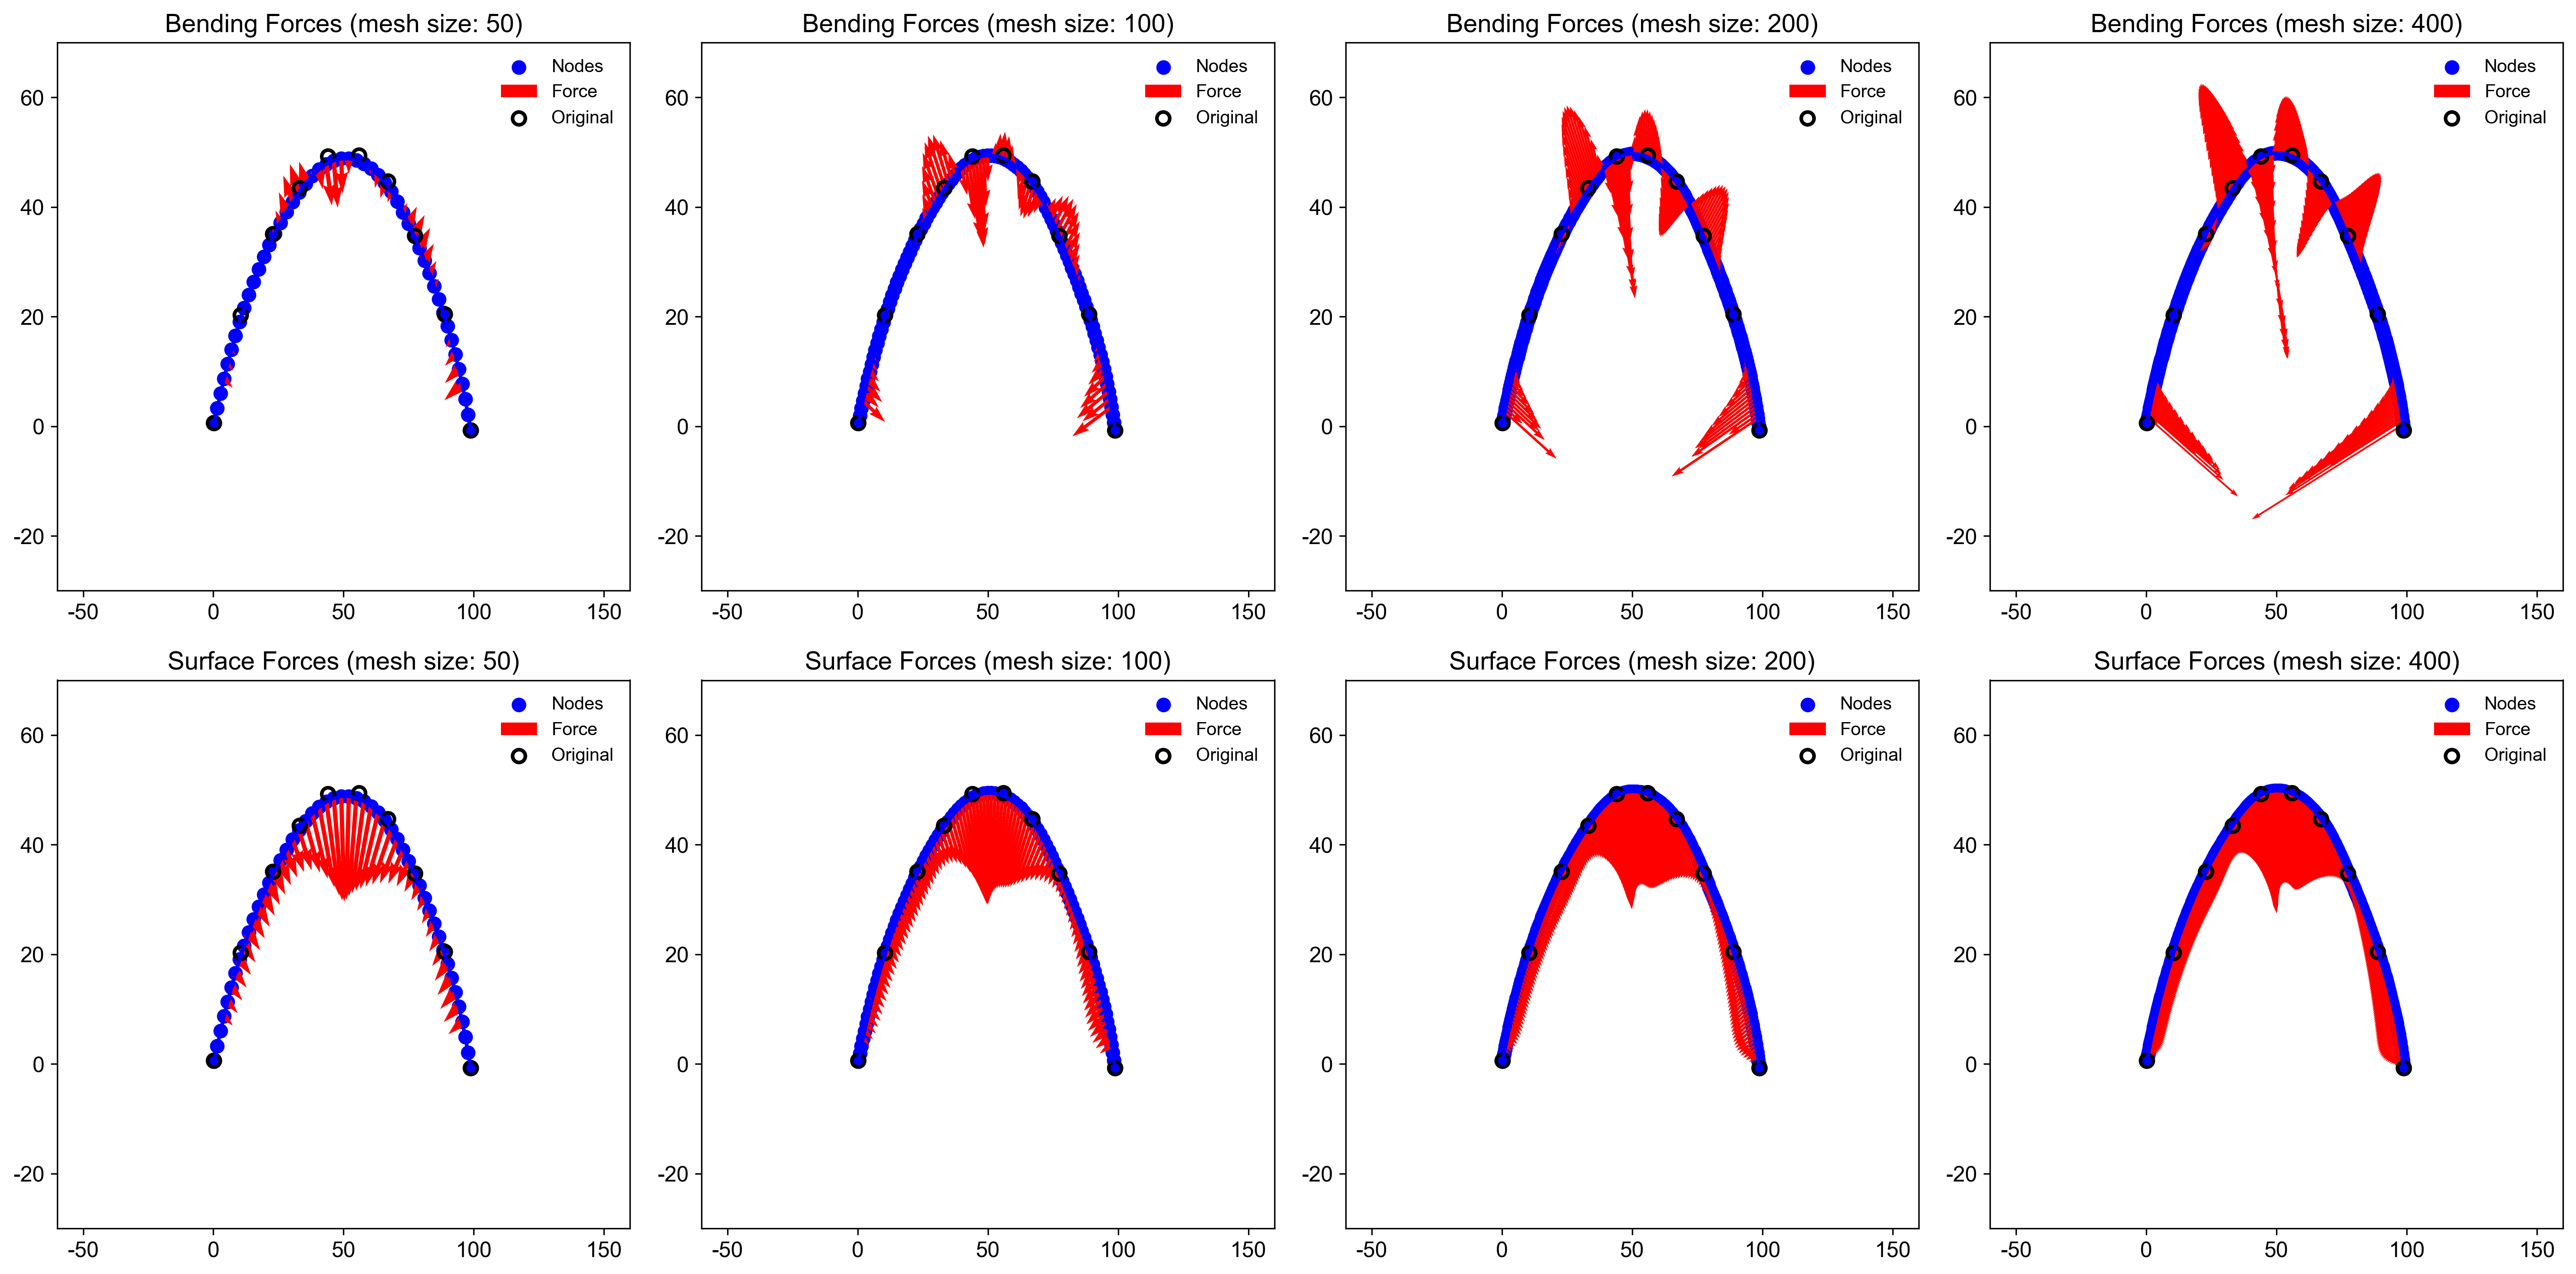

In [7]:
from variation_run import get_force_density
from sample import make_parabola, plot_parabola_ax
import os
import matplotlib.pyplot as plt
import numpy as np

parameters = {
    "Kb":  100 / 4,   # Bending modulus (pN nm)
    "Ksg": 0.5,    # Global stretching modulus (pN nm)
    "Ksl": 0,
    "boundary": "fixed"
}

N_node = 10
noise_level = 0.5
n_vertices_values = [50, 100, 200, 400]
# n_vertices_values = [200, 400, 800, 1600]

# Create subplots for side by side plotting: 2 rows (bending and surface) and len(N_node_values) columns
fig, axes = plt.subplots(2, len(n_vertices_values), figsize=(20, 10))  # 2 rows for bend/surf, columns for mesh sizes

for idx, n_vertices in enumerate(n_vertices_values):

    file_path = os.path.join(f"dat/mesh_test", f"noise_n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}.npz")
    data = np.load(file_path)
    coords = data['coords']
    ori_coords = data['ori_coords']
    force = get_force_density(parameters, coords)

    # Plot Bending Force (row 0)
    plot_parabola_ax(coords, force[0], ax=axes[0, idx], mesh_size=n_vertices, force_type="Bending Forces", scale=500, ori_coords = ori_coords)
    
    # Plot Surface Force (row 1)
    plot_parabola_ax(coords, force[1], ax=axes[1, idx], mesh_size=n_vertices, force_type="Surface Forces", scale=100, ori_coords = ori_coords)


plt.tight_layout()
plt.savefig(f"figures/mesh_test/force_dist_para_noise_n{N_node}.png", dpi=300)
plt.show()


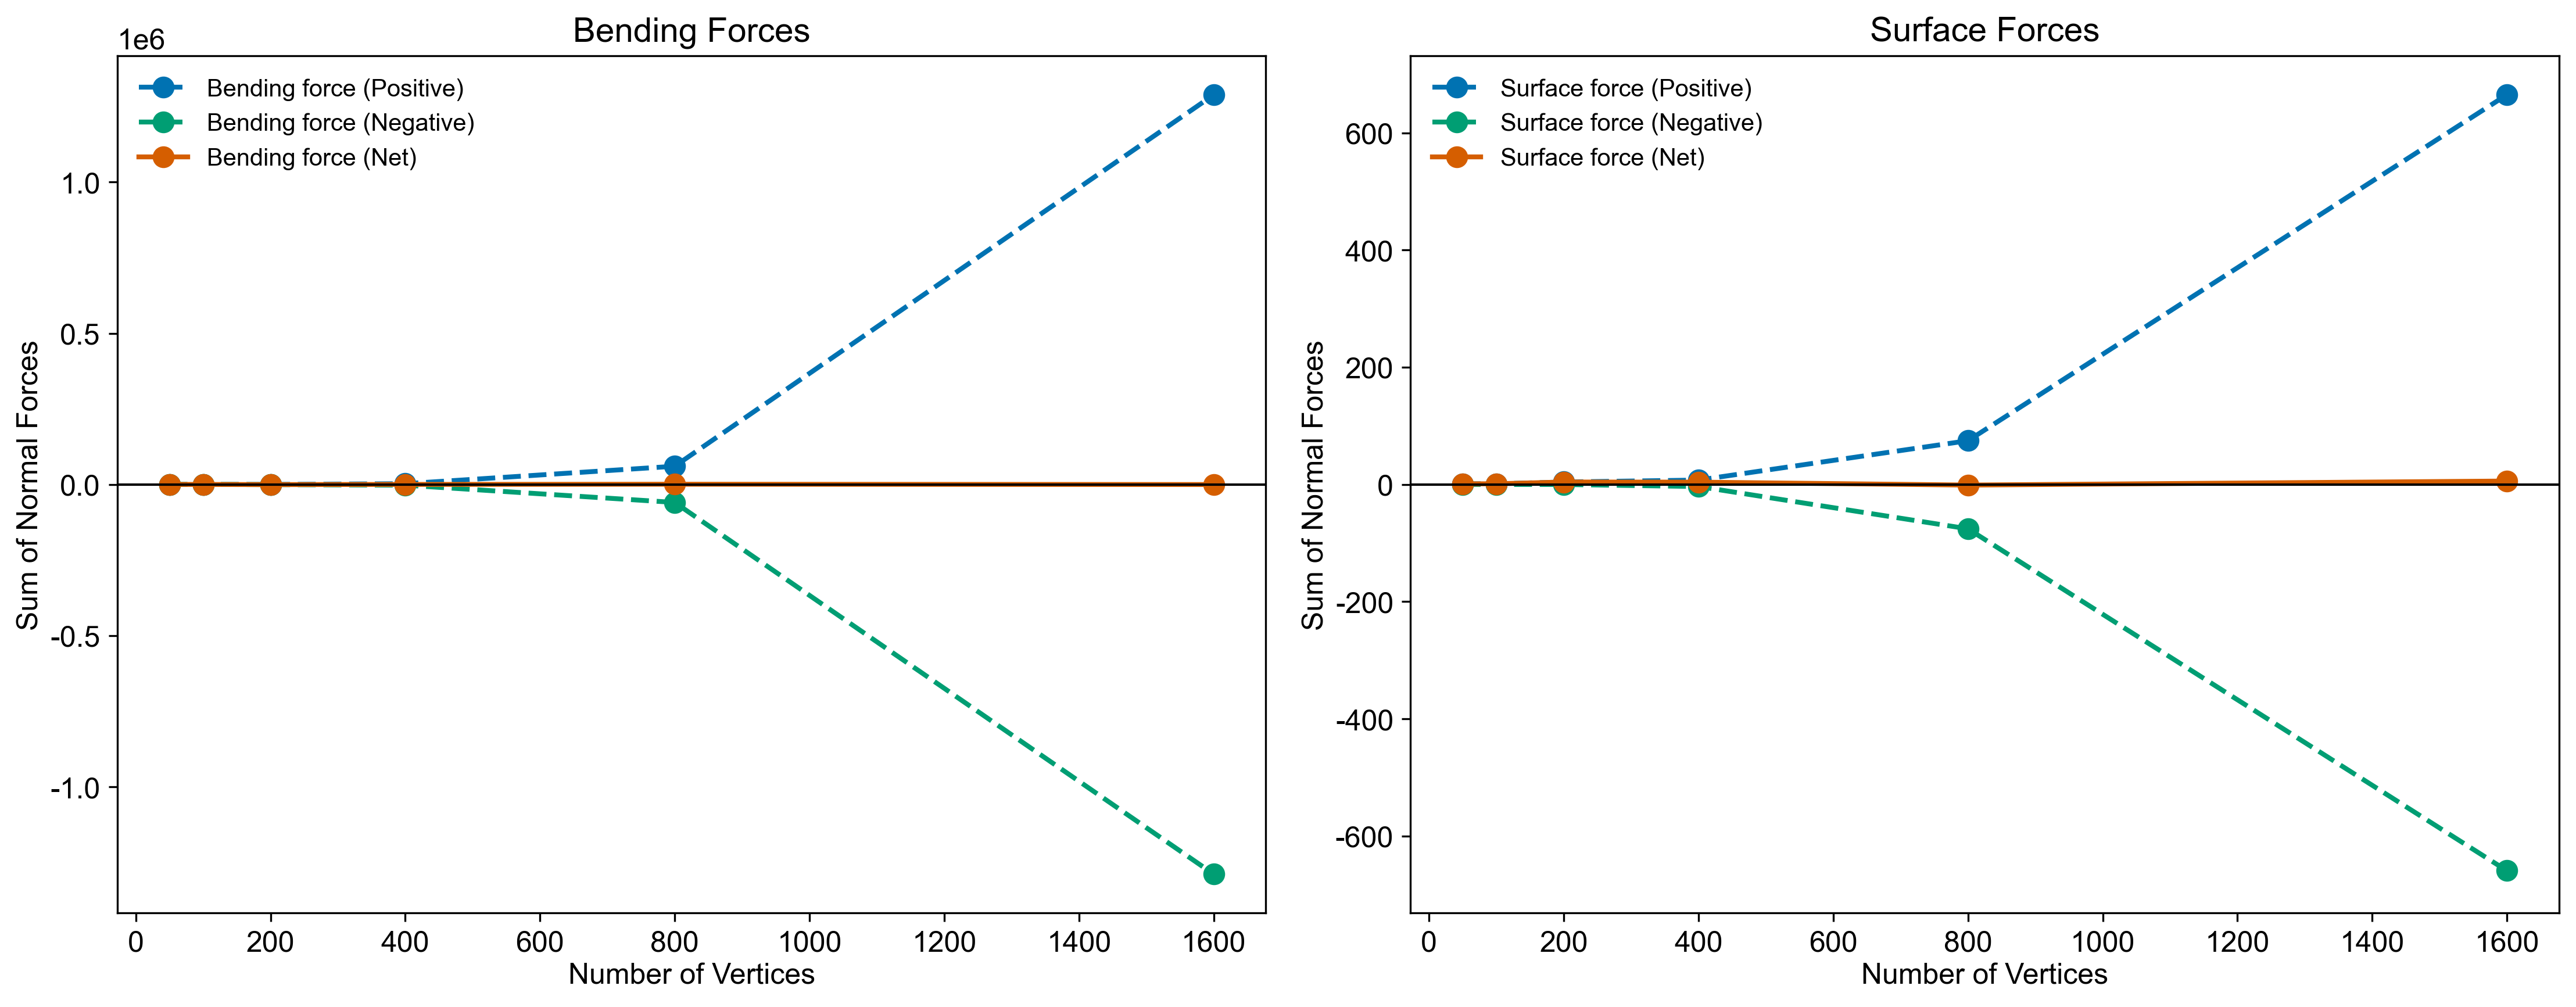

In [6]:
from sample import make_parabola, plot_parabola, plot_norm_side_by_side
from variation_run import get_force_density, get_force
from automembrane.geometry import OpenPlaneCurveGeometry
import numpy as np
import matplotlib.pyplot as plt
import os

L_etoe = 100
height = 50
N_node = 100

parameters = {
    "Kb":  100 / 4,   # Bending modulus (pN nm)
    # "Ksg": 0,    # Global stretching modulus (pN nm)
    "Ksg": 0.5,    # Global stretching modulus (pN nm)
    "Ksl": 0,
    "boundary": "fixed"
}

noise_level = 0.5
# n_vertices_values = [50, 100, 200, 400]
n_vertices_values = [50, 100, 200, 400, 800, 1600]
force_sums_bend = []
force_sums_surf = []

for n_vertices in n_vertices_values:

    file_path = os.path.join(f"dat/mesh_test", f"noise_n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}.npz")
    data = np.load(file_path)
    coords = data['coords']
    forces = get_force(parameters, coords) * OpenPlaneCurveGeometry.vertex_normal(coords)

    positive_force_bend = np.sum(forces[0, forces[0, :] > 0])  # Sum for force > 0
    negative_force_bend = np.sum(forces[0, forces[0, :] < 0])  # Sum for force < 0
    net_force_bend = np.sum(forces[0, :])                      # Net force
    force_sums_bend.append([positive_force_bend, negative_force_bend, net_force_bend])

    positive_force_surf = np.sum(forces[1, forces[1, :] > 0])  # Sum for force > 0
    negative_force_surf = np.sum(forces[1, forces[1, :] < 0])  # Sum for force < 0
    net_force_surf = np.sum(forces[1, :])                      # Net force
    force_sums_surf.append([positive_force_surf, negative_force_surf, net_force_surf])



# Plotting individual plots for bending and surface forces side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

plot_norm_side_by_side(n_vertices_values, force_sums_bend, force_sums_surf, axes)

# Adjust layout for clarity
plt.tight_layout()

plt.savefig(f"figures/mesh_test/normal_force_para_noise_n{N_node}.png", dpi=300)
plt.show()




In [20]:
# Parabola resampled by b-spline and relaxed

from sample import make_parabola, plot_parabola
from variation_relax import resample, relax_bending
import os
import numpy as np

N_node = 30
L_etoe = 100
height = 50
coords = make_parabola(N_node = N_node, L_etoe = L_etoe, height = height, point_dist = "unif")


# n_vertices_values = [200]
# n_vertices_values = [50, 100, 200, 400]
n_vertices_values = [800, 1600]

params = {
    "Kb": 10,
    "Ksg": 10,
    "Ksl": 10,
    "dt": 1e-5,
    # "n_iter": int(8e2), # debug
    "n_iter": int(1e5),
    "boundary": "pinned",
}

for n_vertices in n_vertices_values:

    coords, _ = resample(coords, n_vertices)
    relaxed_coords = relax_bending(coords, **params)

    file_path = os.path.join(f"dat/mesh_test", f"resampled_para_n{n_vertices:03d}.npy")
    np.save(file_path, relaxed_coords)

# plot_parabola(relaxed_coords)


Energy relaxation:   0%|          | 0/100000 [00:00<?, ?it/s]

Energy relaxation:   0%|          | 0/100000 [00:00<?, ?it/s]

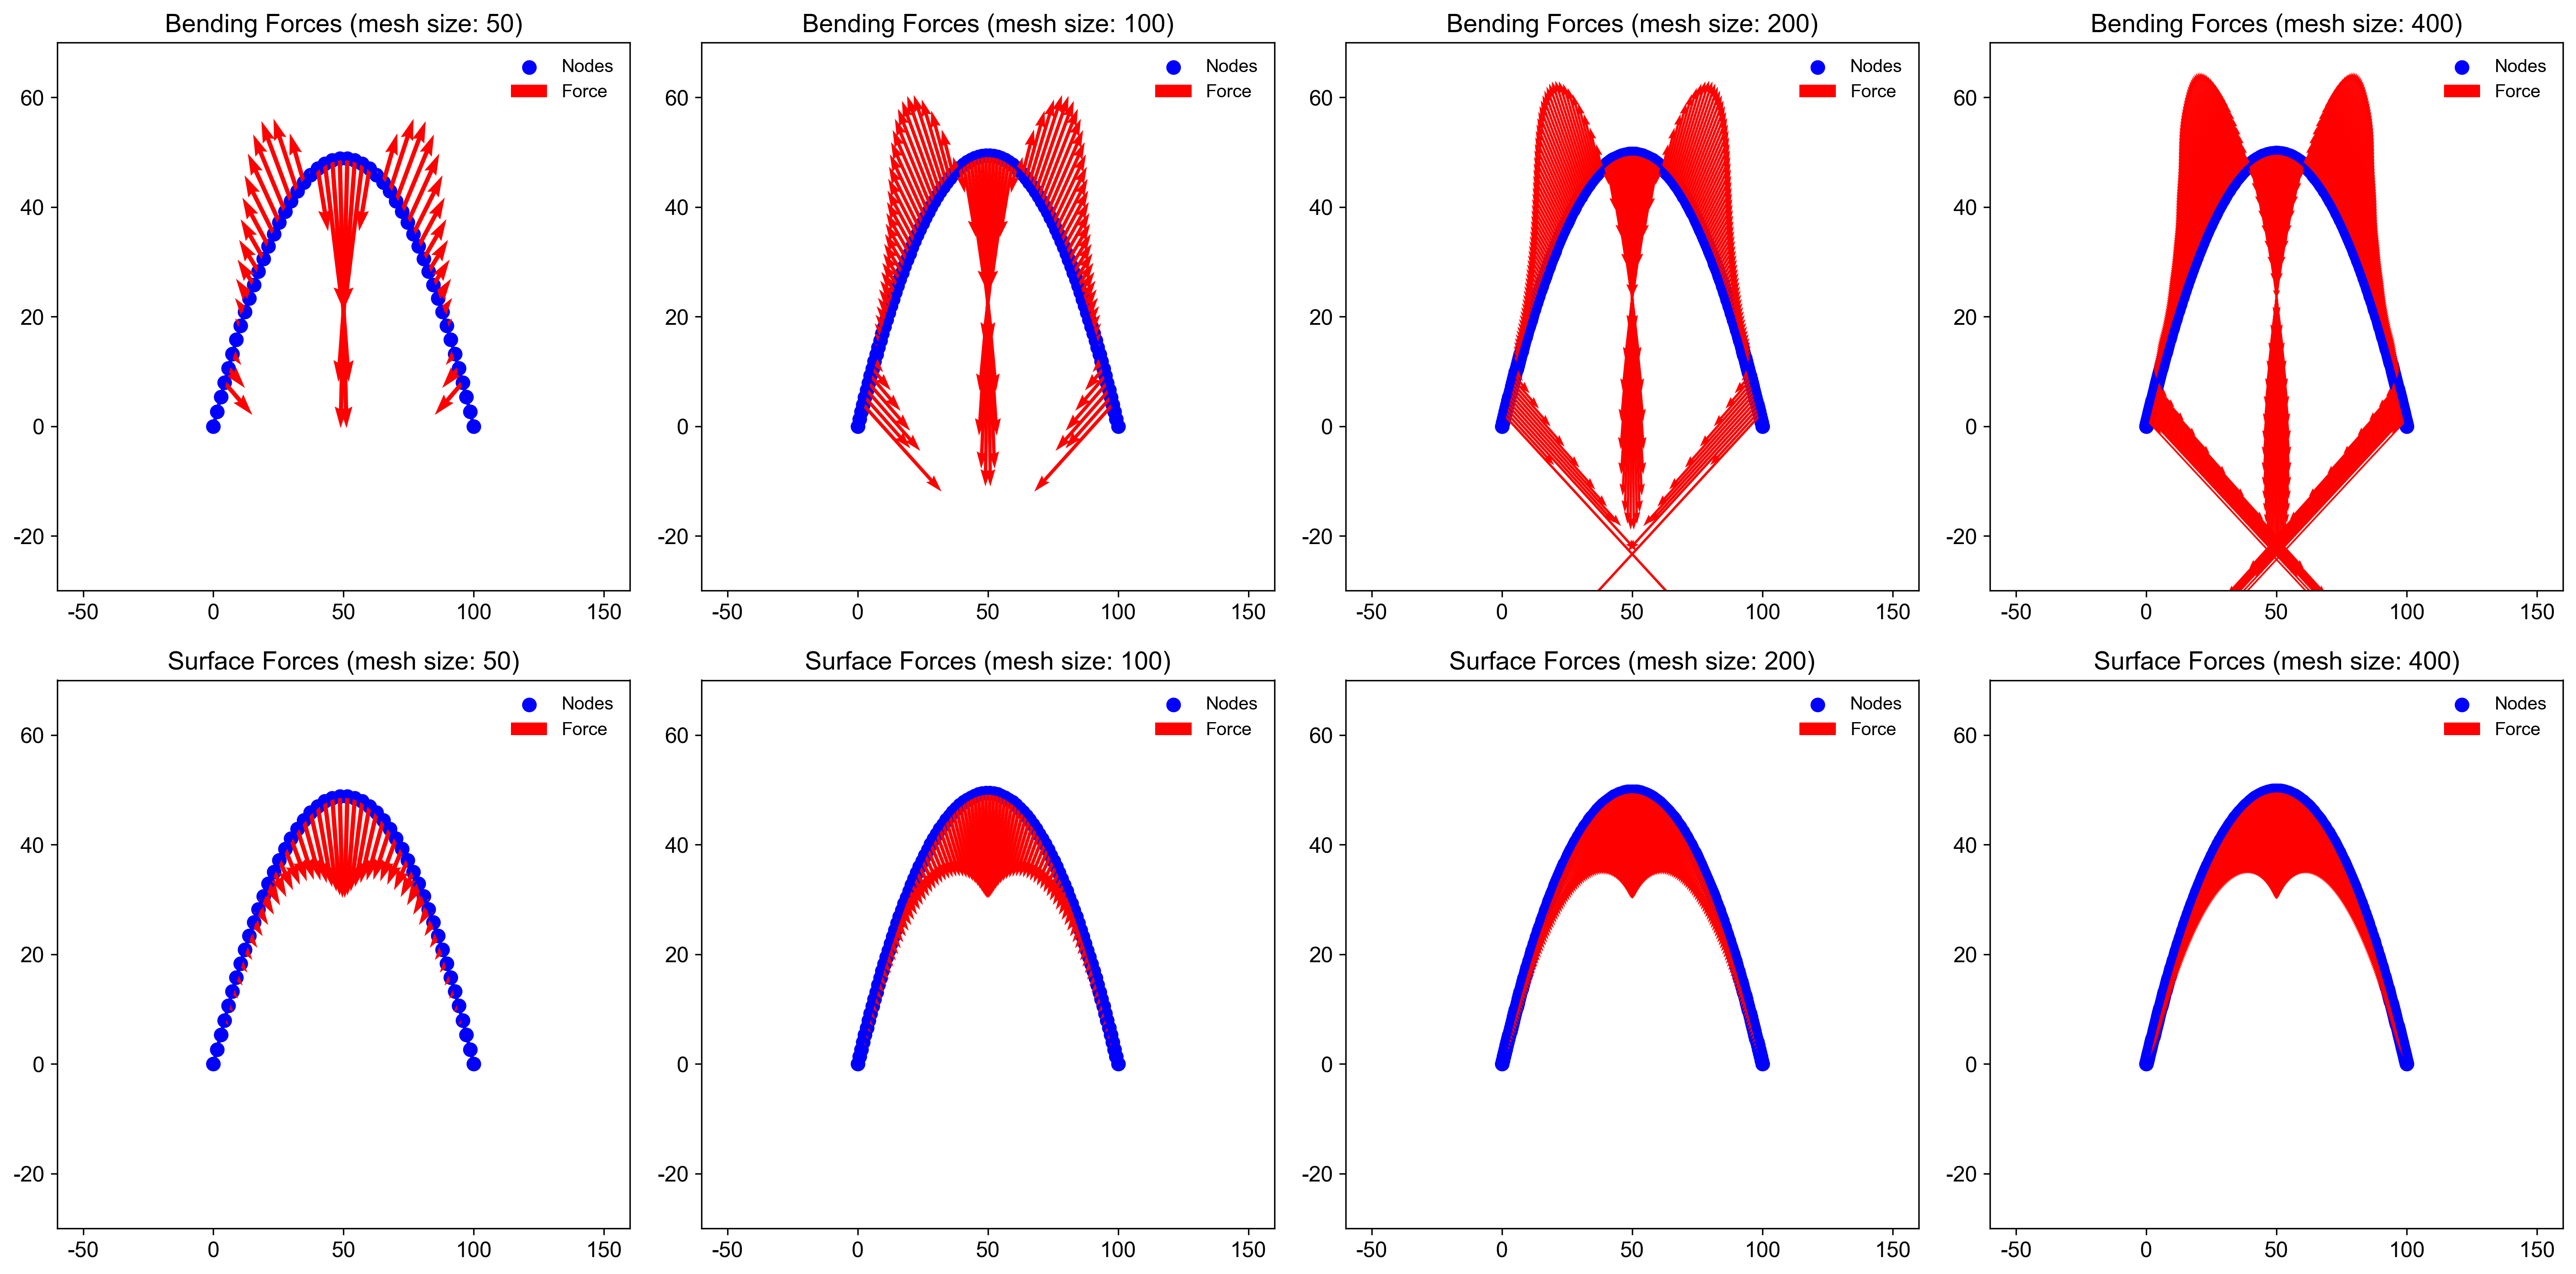

In [22]:
from variation_run import get_force_density
from sample import make_parabola, plot_parabola_ax
import os
import matplotlib.pyplot as plt
import numpy as np

parameters = {
    "Kb":  100 / 4,   # Bending modulus (pN nm)
    "Ksg": 0.5,    # Global stretching modulus (pN nm)
    "Ksl": 0,
    "boundary": "fixed"
}

n_vertices_values = [50, 100, 200, 400]

# Create subplots for side by side plotting: 2 rows (bending and surface) and len(N_node_values) columns
fig, axes = plt.subplots(2, len(n_vertices_values), figsize=(20, 10))  # 2 rows for bend/surf, columns for mesh sizes

for idx, n_vertices in enumerate(n_vertices_values):

    file_path = os.path.join(f"dat/mesh_test", f"resampled_para_n{n_vertices:03d}.npy")
    coords = np.load(file_path)
    force = get_force_density(parameters, coords)

    # Plot Bending Force (row 0)
    plot_parabola_ax(coords, force[0], ax=axes[0, idx], mesh_size=n_vertices, force_type="Bending Forces", scale=10)
    
    # Plot Surface Force (row 1)
    plot_parabola_ax(coords, force[1], ax=axes[1, idx], mesh_size=n_vertices, force_type="Surface Forces", scale=100)


plt.tight_layout()
plt.savefig(f"figures/mesh_test/force_dist_para_resample.png", dpi=300)
plt.show()

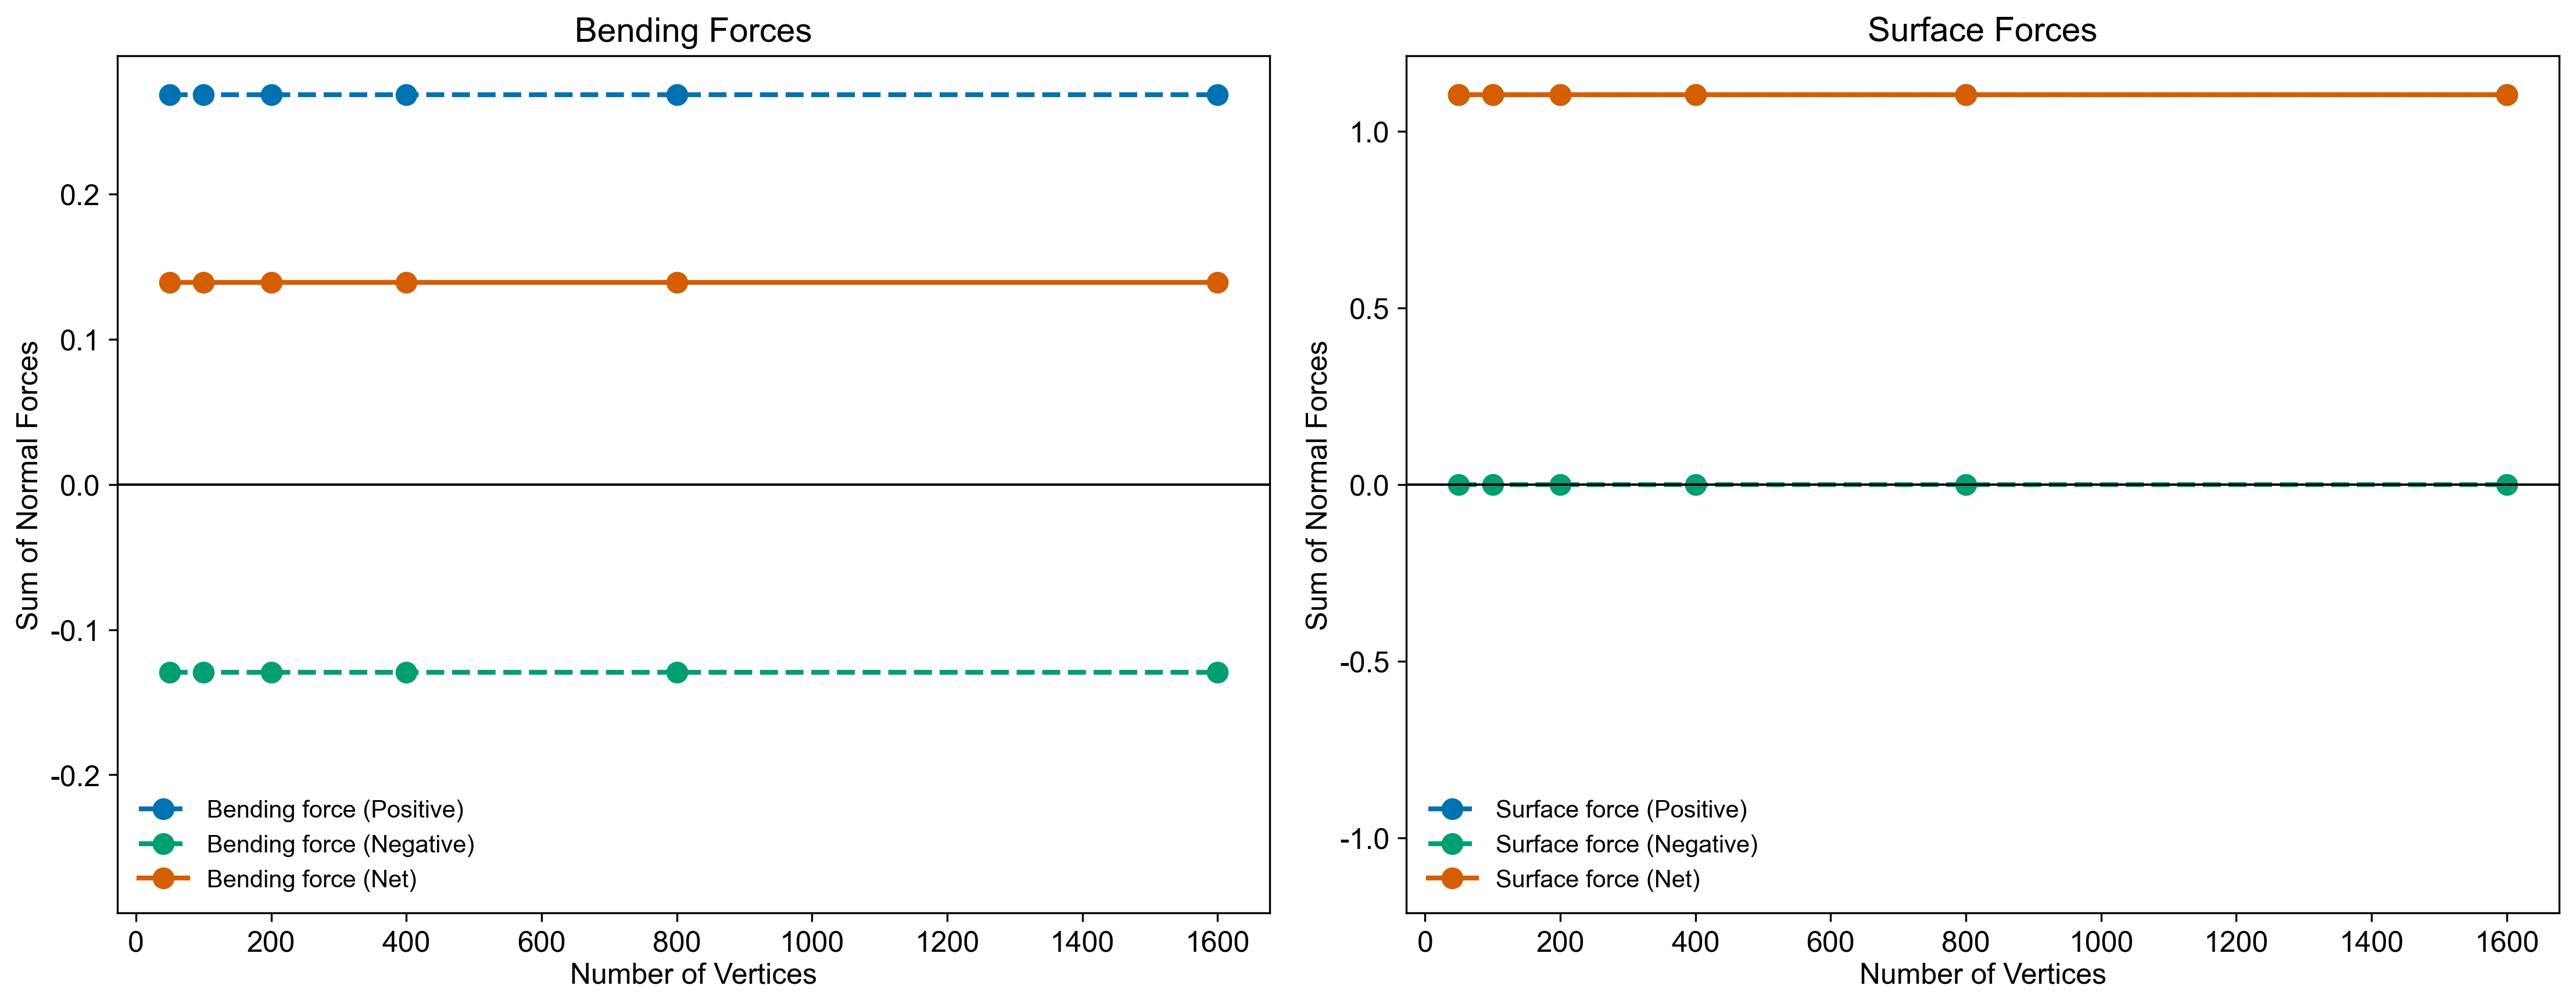

In [21]:
from sample import make_parabola, plot_parabola, plot_norm_side_by_side
from variation_run import get_force_density, get_force
from automembrane.geometry import OpenPlaneCurveGeometry
import numpy as np
import matplotlib.pyplot as plt
import os

L_etoe = 100
height = 50

parameters = {
    "Kb":  100 / 4,   # Bending modulus (pN nm)
    # "Ksg": 0,    # Global stretching modulus (pN nm)
    "Ksg": 0.5,    # Global stretching modulus (pN nm)
    "Ksl": 0,
    "boundary": "fixed"
}

N_node_values = [50, 100, 200, 400, 800, 1600]
force_sums_bend = []
force_sums_surf = []

for N_node in N_node_values:

    file_path = os.path.join(f"dat/mesh_test", f"resampled_para_n{n_vertices:03d}.npy")
    coords = np.load(file_path)
    forces = get_force(parameters, coords) * OpenPlaneCurveGeometry.vertex_normal(coords)

    positive_force_bend = np.sum(forces[0, forces[0, :] > 0])  # Sum for force > 0
    negative_force_bend = np.sum(forces[0, forces[0, :] < 0])  # Sum for force < 0
    net_force_bend = np.sum(forces[0, :])                      # Net force
    force_sums_bend.append([positive_force_bend, negative_force_bend, net_force_bend])

    positive_force_surf = np.sum(forces[1, forces[1, :] > 0])  # Sum for force > 0
    negative_force_surf = np.sum(forces[1, forces[1, :] < 0])  # Sum for force < 0
    net_force_surf = np.sum(forces[1, :])                      # Net force
    force_sums_surf.append([positive_force_surf, negative_force_surf, net_force_surf])



# Plotting individual plots for bending and surface forces side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

plot_norm_side_by_side(N_node_values, force_sums_bend, force_sums_surf, axes)

# Adjust layout for clarity
plt.tight_layout()

plt.savefig(f"figures/mesh_test/normal_force_para_resample.png", dpi=300)
plt.show()

